# Resultados de sociograma

In [42]:
import numpy as np
import math   
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
import pandas as pd
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

## Comentarios sobre el uso

Si un integrante no desea votar a nadiese ingresa como si se hubiese votado a si mismo.
Para grupos pequeños o que se conocen mucho puede ser buena idea pedir más de 2 personas por pregunta.

Los sociogramas se grafican según la carpeta del encuentro "Comunidades Nuevas" realizada por la hermandad de padres operarios.

El gráfico que muestra la relación entre los integrantes del grupo se realiza mediante el layout de fruchterman-reingold.
Esta forma de graficar grafos establece la relación entre los nodos según el peso de las aristas, simulando que cada nodo es un aro de acero cargado negativamente y las aristas son resortes con constante de hook directamente proporcional al peso de las aristas.

## Mejoras a realizar

- Mejorar el cálculo de la relación entre dos miembros. Para miembros con poca relación el valor resultante es lógico, pero tal vez debería ser un poco mayor para miembros con mayor relación.
- Mostrar una lista con los más votados en orden descendiente.
- Investigar que otras preguntas se pueden hacer u otras formas de mostrar/graficar los resultados.

## Preguntas del Sociograma

### I) ¿Con qué dos personas le gustaría trabajar en grupo?

Como resultado obtenemos los referentes del grupo. Los que se relacionan con todos, los más escuchados y los que marcan cierto liderazgo y/o son el apoyo emocional del grupo.

### II) ¿Cuáles son las personas que me gustaría conocer mejor?

Los no votados, o son íntimos de todos, o no son aceptados.
En este caso hay que estudiar el por qué, y también de hacer algo para mejorar la situación.

Presentar el afiche con el gráfico y la sociomatriz y se hace notar quiénes son los más votados y los menos votados.
No se hace ningún comentario sobre estos últimos.
Se explican las coherencias del dibujo, o sea las preferencias o rechazos.

### III) ¿Quiénes podrían darse a conocer más pero no se animan?

El objetivo es impulsar, dejar la invitación a que a partir de ahora cada uno asuma como protagonista la vida de la comunidad, ya no podemos esperar que nos llegue todo hecho, ahora es cada uno quién debe hacer su parte.
Asumir que otros me digan que puedo dar más y que tengo talentos me debe impulsar a dar todo de mi para ofrecerlo a la comunidad.

## Importamos los datos a utilizar

In [197]:
from quintoP import *
from equipoCONU import *
from usuariosCONU import *

## Matriz de votos

In [3]:
def calculateVotesMatrix(members, edges, votesValues):
  matrix = np.zeros((len(edges), members, members))
  for sociogramN in range(len(edges)):
    for vote in edges[sociogramN]:
      for voteN in range(len(vote)-1):
        matrix[sociogramN][vote[0]][vote[voteN+1]] += votesValues[sociogramN][voteN]
  for i in range(members):
    for j in range(len(edges)):
        matrix[j][i][i] = 0
  return matrix

## Cálculo de pocisiones para circuscribir integrantes en circunferencia

In [4]:
def calculateMembersCoordinates(membersQuantity):
  deltaPi = (2 * math.pi) / membersQuantity
  x = []
  y = []
  for i in range(membersQuantity):
    x.append(math.cos(i * deltaPi))
    y.append(math.sin(i * deltaPi))
  coordinates = np.array([x, y])
  return coordinates

## Cálculo de pocisiones de aristas

In [5]:
def edgesVoteN(memCoord, pairs, N):
  edgesx = []
  edgesy = []
  for pair in pairs:
    edgesx.append([memCoord[0][pair[0]], memCoord[0][pair[N+1]]])
    edgesy.append([memCoord[1][pair[0]], memCoord[1][pair[N+1]]])
  edgesx = np.array(edgesx)
  edgesy = np.array(edgesy)
  return edgesx, edgesy  

def calculateEdgesCoordinates(memCoord, allPairs):
  edgesCoordinates = []
  for sociogramPairs in allPairs:
    sociogramEdges = []
    if len(sociogramPairs) != 0:
      for Nvote in range(len(sociogramPairs[0]) - 1):
        sociogramEdges.append(edgesVoteN(memCoord, sociogramPairs, Nvote))
    edgesCoordinates.append(sociogramEdges)
  return np.array(edgesCoordinates)

## Mostrar gráfico de sociograma

In [6]:
def sociograma(members, edges, color=True, showVotes=True, title="Sociograma"):
  if color:
      colors = ("red", "blue")
      width = (1.2, 1)
      opacity = (1, 0.5)
  else:
      colors = ("black", "black")
      width = (1, 1)
      opacity = (1, 1)

  votesValue = [[2,1], [2,1], [2,1]]
  matrix = calculateVotesMatrix(len(members), edges, votesValue)
  memCoordinates = calculateMembersCoordinates(len(members))
  votes = [matrix[i].sum(axis=0, dtype=int) for i in range(len(edges))]
  edgesCoordinates = calculateEdgesCoordinates(memCoordinates, edges)

  fig, axies = plt.subplots(1, len(edges), figsize=(50, 50))
  fig.suptitle(title)
  fig.set_figwidth((len(members)/2) * len(edges))
  fig.set_figheight(len(members)/2)
  if len(edges) == 1:
     axies = [axies]

  for sociogramN in range(len(edges)):
    # Create a figure and axis
    axies[sociogramN].set_xlim(-1.2, 1.2)
    axies[sociogramN].set_ylim(-1.2, 1.2)
    axies[sociogramN].set_aspect('equal')
    axies[sociogramN].set_axis_off()
    if len(axies) != 1:
      axies[sociogramN].set_title("Gráfico " + ("I" * (sociogramN+1)))

    # Plot members
    for memberN in range(len(members)):
      axies[sociogramN].text(memCoordinates[0][memberN], memCoordinates[1][memberN], str(members[memberN]) + ("", f"\n{str(votes[sociogramN][memberN])}")[showVotes],
              bbox={'facecolor': 'white', 'alpha': 0.9, 'boxstyle': "circle"},
              verticalalignment='center', horizontalalignment='center')

    # Plot edges
    if len(edgesCoordinates[sociogramN]) != 0:
      for edgeN in range(len(edgesCoordinates[sociogramN][0][0])):
        for voteN in range(len(edgesCoordinates[sociogramN])):
          axies[sociogramN].plot(edgesCoordinates[sociogramN][voteN][0][edgeN], edgesCoordinates[sociogramN][voteN][1][edgeN], color=colors[voteN], linewidth=width[voteN], alpha=opacity[voteN])

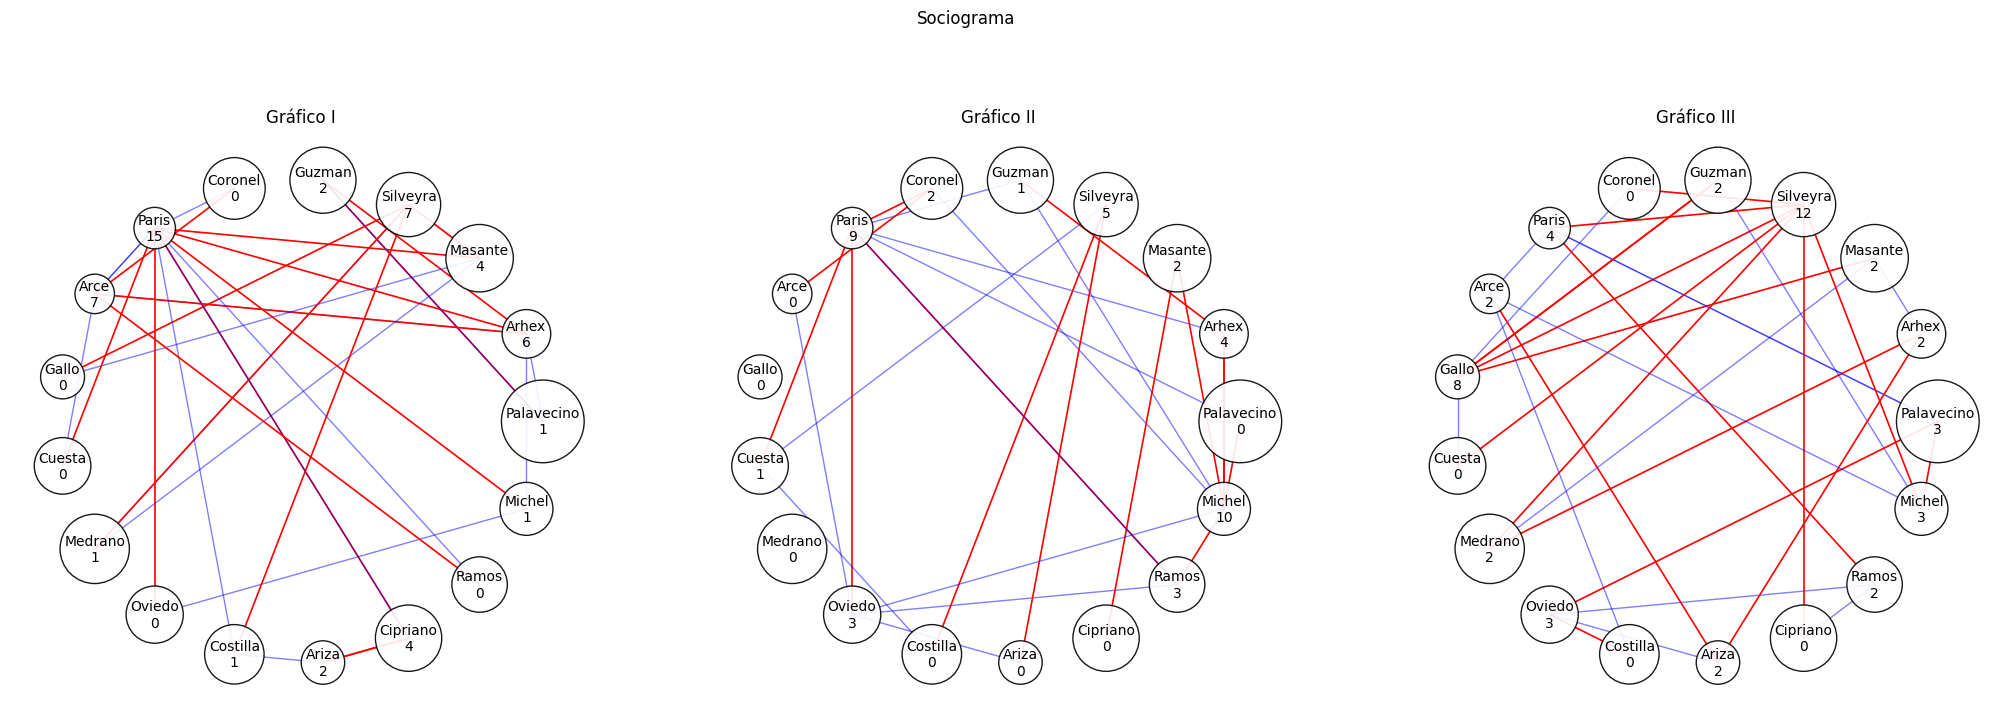

In [7]:
sociograma(quintoP_nombres, [aristas_quintoP_I, aristas_quintoP_II, aristas_quintoP_III])

# Grafos en serio

In [8]:
def calculateRelationsMatrix(members, edges, voteValues):
  matrix = np.zeros((len(members), len(members)))
  # Llenamos la matriz
  for sociogramN in range(len(edges)):
    for vote in edges[sociogramN]:
      for voteN in range(len(vote)-1):
        matrix[vote[0]][vote[voteN+1]] += voteValues[sociogramN][voteN]
  # calculamos el promedio de relación
  for memberA in range(len(members)):
    for memberB in range(memberA):
      averageRelation = (matrix[memberA][memberB] + matrix[memberB][memberA]) / 2
      matrix[memberA][memberB] = averageRelation
      matrix[memberB][memberA] = averageRelation
  # Sumatoria de relaciones en diagonal
  for member in range(len(members)):
    matrix[member][member] = 0
    matrix[member][member] = matrix[member].sum(axis=0)
  return matrix

In [9]:
def makeGraph(members, relationMatrix):
  # Hacemos el grafo  
  graph = nx.Graph()
  #Agregamos los nodos
  graph.add_nodes_from(members)
  # Agregamos aristas
  for i in range(len(members)):
    for j in range(i):
      if relationMatrix[i][j] != 0:
        graph.add_edge(members[i], members[j], weight=relationMatrix[i][j])
  return graph

In [10]:
def relationbtwmembers(graph, member1, member2):
  flowValue, EdgesUsed = nx.maximum_flow(graph, member1, member2, capacity="weight")
  # Borramos las aristas que no fueron utilizadas
  for memberEdge in EdgesUsed:
    deleteList = []
    for key in EdgesUsed[memberEdge]:
      if EdgesUsed[memberEdge][key] == 0:
        deleteList.append(key)
    for deleteKey in deleteList:
      del EdgesUsed[memberEdge][deleteKey]
  # Contamos las aristas que fueron utilizadas
  Nedges = 0
  for memberEdge in EdgesUsed:
    Nedges += len(EdgesUsed[memberEdge])
  value = round(flowValue / (Nedges / 2), 1)
  return value

In [11]:
def graph(members, edges):
  # Matriz de relación
  votesValues = [[50, 45], [25, 20], [5, 4]]
  matrix = calculateRelationsMatrix(members, edges, votesValues)
  # Hacemos el grafo  
  grafo = makeGraph(members, matrix)

  # Dibujamos
  plt.figure(figsize=(15, 15))
  pos = nx.layout.spring_layout(grafo, iterations=900000, seed=12112023)
  nx.draw_networkx(grafo, pos, node_size=4500, width=2, edge_color='gray')
  plt.show()


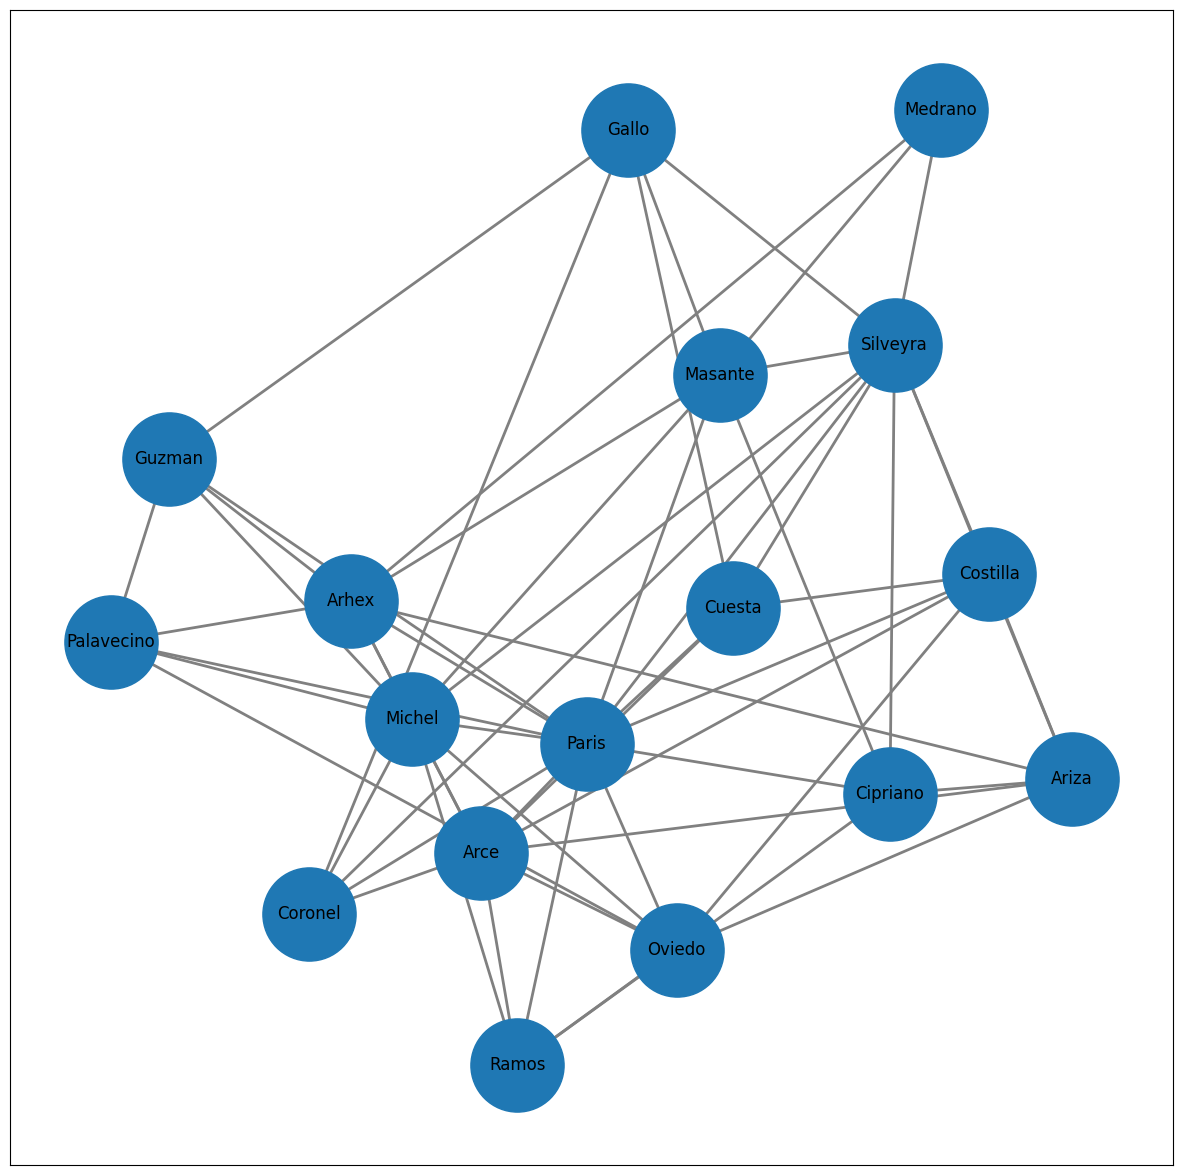

In [12]:
graph(quintoP_nombres, [aristas_quintoP_I, aristas_quintoP_II, aristas_quintoP_III])

## Cálculo de posición de cada miembro y conversión a df

In [13]:
def calculateMembersPosition(members, edges):
  votesValues = [[50, 45], [25, 20], [5, 4]]
  matrix = calculateRelationsMatrix(members, edges, votesValues)
  grafo = makeGraph(members, matrix)
  pos = nx.layout.spring_layout(grafo, iterations=900000, seed=12112023)
  return pos  

In [14]:
def df_pos(member_pos):
  names = []
  xpos = []
  ypos = []

  for name, coords in member_pos.items():
      names.append(name)
      xpos.append(coords[0])
      ypos.append(coords[1])

  # Crear el DataFrame
  df = pd.DataFrame({
      'name': names,
      'xpos': xpos,
      'ypos': ypos
  })
  return df

In [15]:
def showScatter(df):
  plt.scatter(df["xpos"], df["ypos"])
  plt.show()

## K-mean para cálculo de clusters

In [16]:
def k_mean(df_pos, n_clusters):
  colors = ["blue", "red", "green", "yellow", "orange", "purple", "grey", "black"]
  km = KMeans(n_clusters=n_clusters)
  y_predicted = km.fit_predict(df_pos[["xpos", "ypos"]])
  df_pos["cluster"] = y_predicted
  for i in range(n_clusters):
    dfi = df_pos[df_pos.cluster == i]
    plt.scatter(dfi["xpos"], dfi["ypos"], color=colors[i])
  plt.show

In [17]:
pos5p = calculateMembersPosition(quintoP_nombres, [aristas_quintoP_I, aristas_quintoP_II, aristas_quintoP_III])

In [18]:
posconu = calculateMembersPosition(usuarios, [aristas_usuarios_I, aristas_usuarios_II, aristas_usuarios_III])

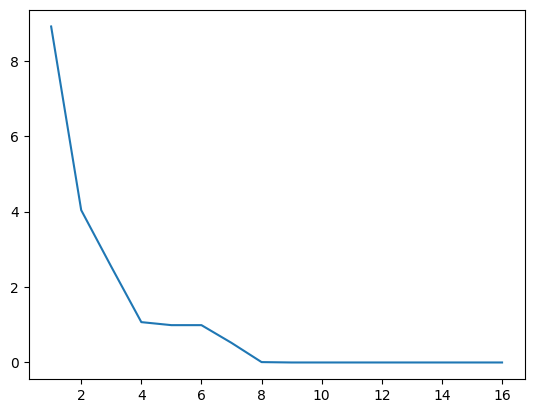

In [19]:
def viewElbow(df_pos, N=100):
  k_rng = range(1, len(df_pos))
  sse = np.zeros(len(df_pos)-1, dtype=int)
  for _ in range(N-1):
    for k in k_rng:
      km = KMeans(n_clusters=k)
      km.fit(df_pos[["xpos", "ypos"]])
      sse[k-1] += km.inertia_
  sse = sse / N
  plt.plot(k_rng, sse)

viewElbow(df_pos(pos5p))

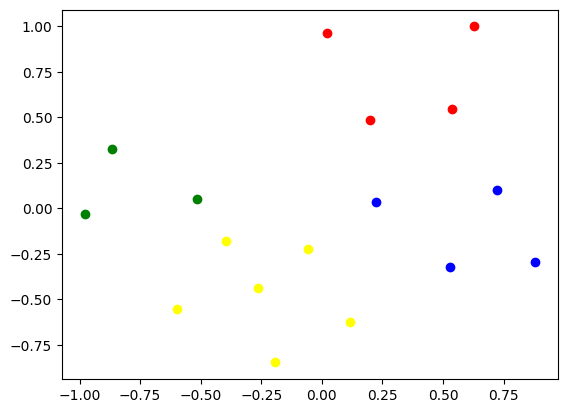

In [20]:
clusters = 4
k_mean(df_pos(pos5p), clusters)

## Clustering with DBSCAN

Se intentó hacer una prueba con DBSCAN y no fue muy fructífera.
Luego de una investigación se decidió que no era tan buena idea utilizar este método.

## Clustering with spectral clustering

### Matriz de afinidad

In [36]:
def sc_degreeMatrix(members, edges, voteRates):
  neutral_relation = 1
  matrix = np.empty((len(members), len(members)))
  matrix.fill(neutral_relation)
  # Llenamos la matriz
  for sociogramN in range(len(edges)):
    for vote in edges[sociogramN]:
      for voteN in range(len(vote)-1):
        matrix[vote[0]][vote[voteN+1]] *= voteRates[sociogramN][voteN]
  # calculamos el promedio de relación
  for memberA in range(len(members)):
    for memberB in range(memberA):
      averageRelation = (matrix[memberA][memberB] + matrix[memberB][memberA]) / 2
      matrix[memberA][memberB] = averageRelation
      matrix[memberB][memberA] = averageRelation
  # Ceros en la diagonal
  for member in range(len(members)):
    matrix[member][member] = 0
  return matrix

In [227]:
afinidad_5p = sc_degreeMatrix(quintoP_nombres, [aristas_quintoP_I, aristas_quintoP_II, aristas_quintoP_III], [[10, 9], [4, 3], [0, 0.1]])

In [228]:
# Matriz Laplaciana normalizada
L = laplacian(afinidad_5p, normed=True)

# Calcular los k menores eigenvectores del Laplaciano
k = 2  # Número de clusters
eigenvalues, eigenvectors = eigh(L)
V = eigenvectors[:, :k]  # Tomamos los primeros k eigenvectores

# Aplicar k-means en los primeros k eigenvectores
kmeans = KMeans(n_clusters=k)
kmeans.fit(V)
labels = kmeans.labels_

# Imprimir las etiquetas de cada punto
print("Labels de los clusters:", labels)

clusters = [[] for _ in range(k)]

for membern in range(len(quintoP_nombres)-1):
  clusters[labels[membern]].append(quintoP_nombres[membern])

clusters


Labels de los clusters: [1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1]


[['Masante', 'Silveyra', 'Gallo', 'Medrano', 'Costilla', 'Ariza', 'Cipriano'],
 ['Palavecino',
  'Arhex',
  'Guzman',
  'Coronel',
  'Paris',
  'Arce',
  'Cuesta',
  'Oviedo',
  'Ramos']]

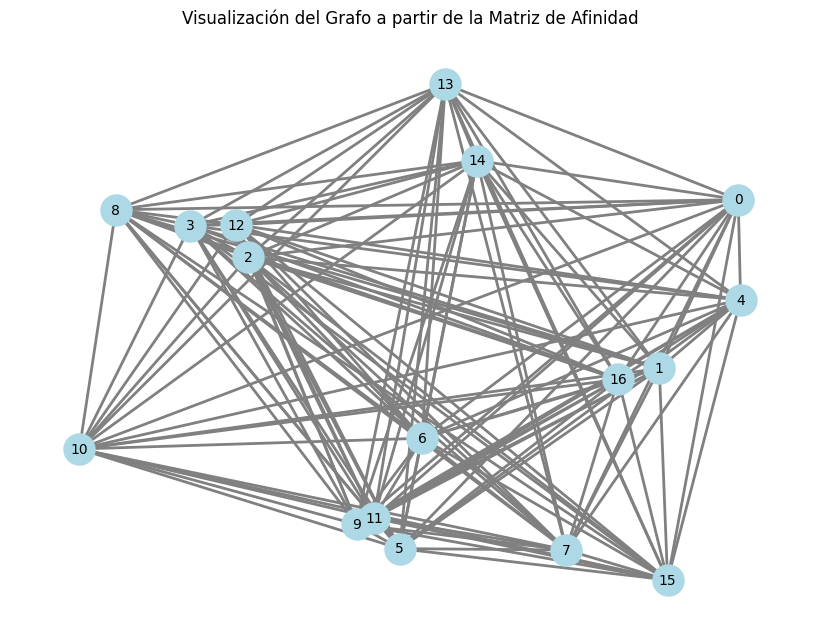

In [230]:
# Crear el grafo a partir de la matriz de afinidad
sc_grafo = nx.from_numpy_array(afinidad_5p * 2000)

# Posicionar los nodos usando el algoritmo de Fruchterman-Reingold
pos = nx.spring_layout(sc_grafo, iterations=900000)

# Dibujar el grafo
plt.figure(figsize=(8, 6))
nx.draw(sc_grafo, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, width=2)
labels = nx.get_edge_attributes(sc_grafo, 'weight')
nx.draw_networkx_edge_labels(sc_grafo, pos, edge_labels="")
plt.title("Visualización del Grafo a partir de la Matriz de Afinidad")
plt.show()

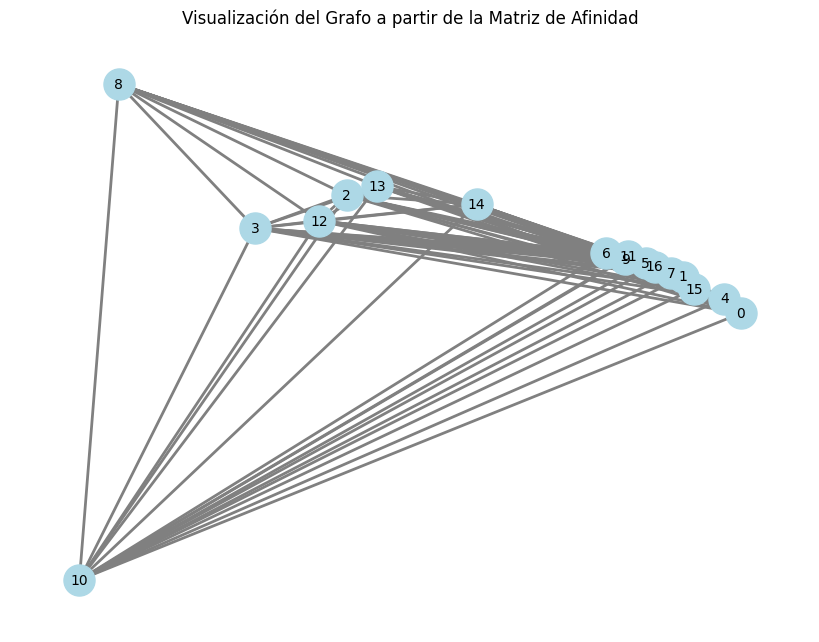

In [231]:
# Crear el grafo a partir de la matriz de afinidad
sc_grafo = nx.from_numpy_array(afinidad_5p * 10000)

# Posicionar los nodos usando el algoritmo de Fruchterman-Reingold
pos_spectral = nx.spectral_layout(sc_grafo)

# Dibujar el grafo
plt.figure(figsize=(8, 6))
nx.draw(sc_grafo, pos_spectral, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, width=2)
labels = nx.get_edge_attributes(sc_grafo, 'weight')
nx.draw_networkx_edge_labels(sc_grafo, pos, edge_labels="")
plt.title("Visualización del Grafo a partir de la Matriz de Afinidad")
plt.show()